# AlexNet on CIFAR-10 with TensorFlow Keras

This notebook shows how to recreate the AlexNet image classifier using **TensorFlow Keras**, and how to train it on the **CIFAR-10** dataset.

You will learn:

- What AlexNet is and why it mattered
- How convolution, pooling, and fully-connected layers work
- How to prepare image data for a neural network
- How to choose loss functions, optimizers, and metrics
- How to train and evaluate a model in Keras

**Audience:** Readers with little or no modern AI/ML background. We explain each concept as we use it.


## 1. What is AlexNet?

**AlexNet** (2012) is a convolutional neural network (CNN) that helped spark the modern deep-learning boom. It introduced:

- Stacked **convolution layers** with **ReLU** activations
- **Max pooling** to reduce spatial size while keeping strong features
- **Dropout** to reduce overfitting
- A large **fully-connected** classifier head

We will recreate the _core ideas_ of AlexNet using Keras. The original AlexNet was trained on 224x224 or 227x227 images (ImageNet). **CIFAR-10 images are only 32x32**, so we will **resize** them for a closer match and keep the model size manageable for a tutorial.

## 2. The CIFAR-10 dataset

CIFAR-10 contains **60,000 color images** in 10 classes (airplane, car, bird, cat, deer, dog, frog, horse, ship, truck). We will use **50,000 for training** and **10,000 for testing**.


## 3. Setup

We will use **TensorFlow Keras**, which provides high-level building blocks for neural networks. If you are running locally and need to install TensorFlow:

```bash
pip install tensorflow
```

or

```bash
uv add tensorflow
```

We also set a random seed so results are easier to reproduce.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


## 4. Load CIFAR-10

Keras can download CIFAR-10 for us. The data comes as **NumPy arrays**:

- `x_train`: training images
- `y_train`: training labels (0-9)
- `x_test`, `y_test`: test set

Each image has shape **32x32x3** (height, width, color channels).


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step
Train images: (50000, 32, 32, 3)
Train labels: (50000, 1)
Test images: (10000, 32, 32, 3)
Test labels: (10000, 1)


/Users/pmui/SynologyDrive/research/2026/research2026/01-nn/.venv/lib/python3.12/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


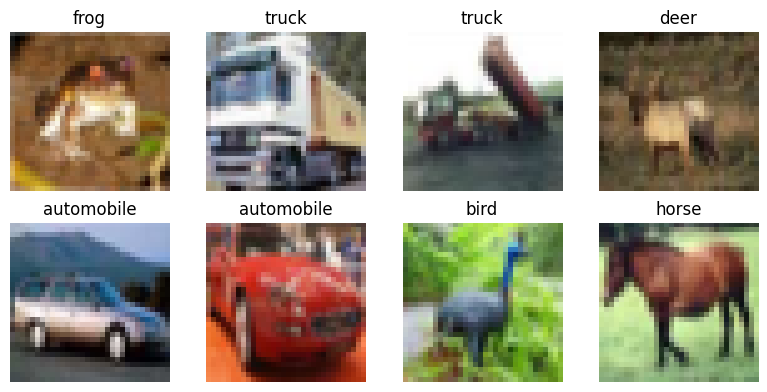

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("Train images:", x_train.shape)
print("Train labels:", y_train.shape)
print("Test images:", x_test.shape)
print("Test labels:", y_test.shape)

# Show a few sample images
plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 5. Preprocess the data

Neural networks learn best when inputs are scaled to small ranges.

We will:

1. **Normalize** pixel values from 0-255 to 0-1.
2. **Resize** images to 227x227 so they match AlexNet's expected input size.
3. Build **tf.data pipelines** for efficient loading, shuffling, and batching.
4. Apply **data augmentation** (small random flips and shifts) to reduce overfitting.

**Why resize?** AlexNet was designed for larger images. Resizing keeps the architecture closer to the original, but increases computation. You can use a smaller input size if you want faster training.


In [3]:
BATCH_SIZE = 64
IMG_SIZE = 227

# Data augmentation only for training
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Preprocessing: normalize and resize
preprocess = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255),
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
])

def prepare_dataset(images, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if training:
        ds = ds.shuffle(5000, seed=SEED)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (augment(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = prepare_dataset(x_train, y_train, training=True)
test_ds = prepare_dataset(x_test, y_test, training=False)

## 6. AlexNet architecture

A **convolutional neural network (CNN)** learns visual patterns using small filters that slide across the image.

### Convolution layers

- A **filter/kernel** is a small matrix (e.g., 11x11) that detects patterns like edges or textures.
- **Stride** controls how far the filter moves each step. Larger stride = fewer outputs.
- **Padding** adds zeros around the image so the output size does not shrink too fast.

### Activation (ReLU)

- **ReLU** replaces negative values with 0. This speeds up training and helps gradients flow.

### Pooling layers

- **Max pooling** keeps the strongest value in each small window (e.g., 3x3). It reduces size and keeps key features.
- **Average pooling** keeps the mean instead. It is smoother but can lose sharp features.

### Fully-connected layers

- After convolutions, we **flatten** the feature maps and feed them to dense layers for classification.

### Dropout

- **Dropout** randomly removes a fraction of neurons during training, which reduces overfitting.

AlexNet uses large filters in early layers and smaller filters later. We will keep that pattern.


In [4]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # 1st conv block
    layers.Conv2D(96, kernel_size=11, strides=4, padding="valid", activation="relu"),
    layers.MaxPooling2D(pool_size=3, strides=2),

    # 2nd conv block
    layers.Conv2D(256, kernel_size=5, strides=1, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=3, strides=2),

    # 3rd-5th conv blocks
    layers.Conv2D(384, kernel_size=3, strides=1, padding="same", activation="relu"),
    layers.Conv2D(384, kernel_size=3, strides=1, padding="same", activation="relu"),
    layers.Conv2D(256, kernel_size=3, strides=1, padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=3, strides=2),

    # Classifier head
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,715,338 (52.32 MB)

 Trainable params: 13,715,338 (52.32 MB)

 Non-trainable params: 0 (0.00 B)

**Note on differences vs the original AlexNet**

- The original AlexNet used **Local Response Normalization (LRN)** and **very large fully-connected layers (4096 units)**. LRN is less common today and not built into Keras. We omit it for simplicity.
- We **scale down the dense layers** (1024 and 512 units) to make training feasible on smaller hardware and a smaller dataset.

The **key ideas**--stacked convolutions, max pooling, ReLU, and dropout--are preserved.


## 7. Loss function, optimizer, and metrics

### Loss (what we optimize)

We are doing **multi-class classification** (10 classes). Each image belongs to exactly one class.

We will use **Sparse Categorical Crossentropy**:

- "Categorical" means multi-class
- "Sparse" means labels are integers (0-9) instead of one-hot vectors

**Common alternatives:**

- `CategoricalCrossentropy` if your labels are one-hot encoded
- `BinaryCrossentropy` for two classes or multi-label tasks

### Optimizer (how we update weights)

We will use **Adam**, a popular optimizer that adapts the learning rate for each parameter.

**Common alternatives:**

- **SGD** (Stochastic Gradient Descent): simpler and sometimes more stable
- **RMSprop**: good for noisy gradients
- **Adagrad**: adapts learning rates but can slow too much later

### Metrics (how we measure progress)

We will use **accuracy**. It reports the percentage of correct predictions.

**Common alternatives:**

- **Top-K accuracy** (correct if the true class is in the top K predictions)
- **Precision/Recall/F1** (useful for imbalanced data)


In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

## 8. Train the model

Training means showing the network images and labels, then adjusting weights to reduce the loss.

Key parameters:

- **Epochs**: how many times we pass through the full training set
- **Batch size**: number of images per training step (set in the dataset pipeline)
- **Learning rate**: how big each weight update is

We will train for a small number of epochs to keep this tutorial fast. You can increase it later.


In [ ]:
%%time

if os.path.exists("models/alexnet_cifar10.weights.h5"):
    model.load_weights("models/alexnet_cifar10.weights.h5")
else:
    EPOCHS = 10

    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=EPOCHS,
    )
    model.save("models/alexnet_cifar10.keras")
    model.save_weights("models/alexnet_cifar10.weights.h5")

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 924s 1s/step - accuracy: 0.3275 - loss: 1.7991 - val_accuracy: 0.4911 - val_loss: 1.4109
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 927s 1s/step - accuracy: 0.5045 - loss: 1.3626 - val_accuracy: 0.6151 - val_loss: 1.0882
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 893s 1s/step - accuracy: 0.6046 - loss: 1.1264 - val_accuracy: 0.6910 - val_loss: 0.8844
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 835s 1s/step - accuracy: 0.6627 - loss: 0.9659 - val_accuracy: 0.7322 - val_loss: 0.7753
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 822s 1s/step - accuracy: 0.7052 - loss: 0.8482 - val_accuracy: 0.7502 - val_loss: 0.7296
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 808s 1s/step - accuracy: 0.7385 - loss: 0.7606 - val_accuracy: 0.7607 - val_loss: 0.6928
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 848s 1s/step - accuracy: 0.7619 - loss: 0.6909 - val_accuracy: 0.7750 - val_loss: 0.6631
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 818s 1s/step - accuracy: 0.7811 - loss: 0.6370 - val_accu

## 9. Evaluate and visualize results

We can evaluate accuracy on the test set and plot the training curves. We will also build a simple confusion matrix to see which classes are commonly confused.


Test accuracy: 0.827


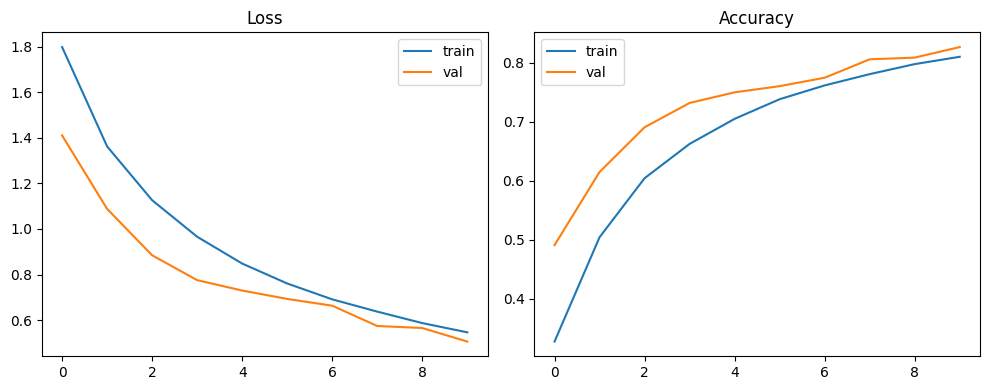

2026-01-24 19:37:10.086863: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


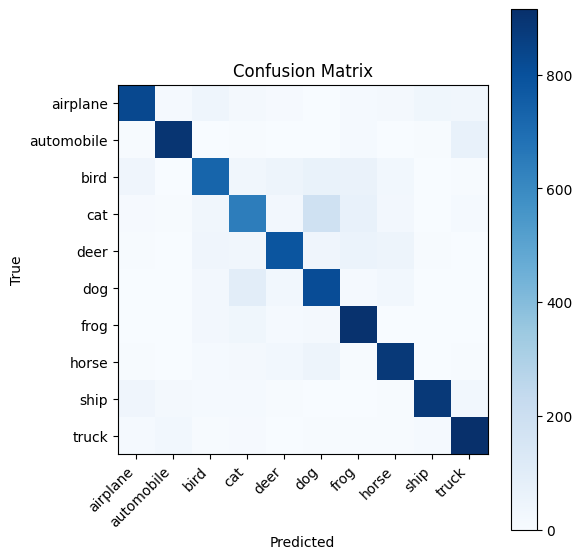

In [8]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")

# Plot learning curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix
all_preds = []
all_labels = []
for batch_imgs, batch_labels in test_ds:
    preds = model.predict(batch_imgs, verbose=0)
    all_preds.append(np.argmax(preds, axis=1))
    all_labels.append(batch_labels.numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = tf.math.confusion_matrix(all_labels, all_preds, num_classes=10).numpy()

plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.yticks(range(10), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()

## 10. Key takeaways and next steps

- **Convolution layers** learn spatial features (edges -> textures -> parts -> objects).
- **Pooling** reduces spatial size and helps the model become more robust to small shifts.
- **Fully-connected layers** combine learned features to make the final decision.
- **Loss functions** measure how wrong predictions are; we minimize them.
- **Optimizers** decide how to update weights; Adam is a strong default.
- **Metrics** help you track progress, but the loss is what the model actually optimizes.

### Common improvements to try

- Use **Batch Normalization** after convolutions to stabilize training.
- Switch to **SGD + momentum**, which sometimes yields better final accuracy.
- Increase **epochs** and add a **learning-rate schedule**.
- Try **smaller input size** (e.g., 64x64) for faster training.
- Explore more modern architectures (VGG, ResNet, EfficientNet).

If you are new to ML, try adjusting one thing at a time and observe how the training curves change.
